In [1]:
library('tidyverse')
library('ggrepel')
library('ggbeeswarm')
library('readxl')
library('limma')
library('edgeR')

org_opts <- options()

── Attaching packages ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0      ✔ purrr   1.0.1 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.3.0      ✔ stringr 1.5.0 
✔ readr   2.1.3      ✔ forcats 0.5.2 
── Conflicts ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


In [2]:
exp_matrix <-
    read_xlsx('counts raw chondrosarcoma.xlsx', sheet='TargetCountMatrix')

exp_matrix %>%
    head()

TargetName,NMS23-471 | 001 | S100B,NMS23-471 | 002 | S100B,NMS23-471 | 003 | S100B,NMS23-471 | 004 | S100B,NMS23-471 | 005 | CD68,NMS23-471 | 005 | CD3,NMS23-471 | 006 | CD68,NMS23-471 | 006 | CD3,NMS23-471 | 007 | CD68,⋯,S10-479 | 013 | CD3,S10-479 | 013 | S100,S10-479 | 014 | CD68,S10-479 | 014 | CD3,S10-479 | 014 | S100,S10-479 | 015 | CD68,S10-479 | 015 | CD3,S10-479 | 015 | S100,S10-479 | 016 | CD68,S10-479 | 016 | CD3
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
RFC3,1.245731,1.741101,1.319508,1.148698,1,1.000000,1,1,1.000000,⋯,1.000000,2.701920,1.000000,1,1.245731,1.319508,1.245731,1.000000,1.430969,1.888175
PSMB5,2.047673,1.148698,1.888175,1.245731,1,1.319508,1,1,1.000000,⋯,1.148698,2.605171,1.643752,1,1.430969,1.000000,1.000000,1.430969,1.643752,1.148698
POLD4,1.741101,1.000000,1.430969,1.515717,1,1.245731,1,1,1.000000,⋯,1.319508,4.324246,1.148698,1,1.782602,1.319508,1.319508,1.000000,1.430969,1.245731
MAP3K8,1.430969,1.245731,1.430969,1.000000,1,1.000000,1,1,1.000000,⋯,1.000000,2.701920,1.430969,1,2.111786,1.319508,1.000000,1.430969,1.319508,1.000000
IRF9,1.515717,1.148698,1.888175,1.148698,1,1.000000,1,1,1.148698,⋯,1.430969,4.042823,1.148698,1,1.741101,1.148698,1.148698,1.430969,1.000000,1.430969
PAX3,1.643752,1.148698,1.000000,1.515717,1,1.000000,1,1,1.000000,⋯,1.245731,3.758480,1.000000,1,2.352158,1.000000,1.148698,1.148698,1.148698,1.245731


In [3]:
tumor_vs_peritumor <-
    read_xlsx('normalized raw chondrosarcoma.xlsx', sheet='TargetCountMatrix', n_max=1, col_names=paste('c', 1:141, sep='_')) %>%
    t()

tumor_vs_peritumor %>%
    head()

c_1,tumor
c_2,tumor
c_3,tumor
c_4,tumor
c_5,peritumor
c_6,peritumor


In [4]:
sample_annotations <-
    tibble(
        `sample_desc`=exp_matrix %>% select(-`TargetName`) %>% colnames(),
        `region_type`=tumor_vs_peritumor %>% as.vector()
    ) %>%
    separate(`sample_desc`, c('sample_name', 'region_id', 'marker'), sep=' \\| ', remove=FALSE) %>%
    mutate(`marker`=case_when(
        `marker` == 'S100' ~ 'S100B',
        `marker` == 'DAPI' ~ 'S100B',
        TRUE ~ `marker`
    ))

sample_annotations %>%
    head()

sample_desc,sample_name,region_id,marker,region_type
<chr>,<chr>,<chr>,<chr>,<chr>
NMS23-471 | 001 | S100B,NMS23-471,001,S100B,tumor
NMS23-471 | 002 | S100B,NMS23-471,002,S100B,tumor
NMS23-471 | 003 | S100B,NMS23-471,003,S100B,tumor
NMS23-471 | 004 | S100B,NMS23-471,004,S100B,tumor
NMS23-471 | 005 | CD68,NMS23-471,005,CD68,peritumor
NMS23-471 | 005 | CD3,NMS23-471,005,CD3,peritumor


In [5]:
exp_tbl <-
    exp_matrix %>%
    pivot_longer(
        names_to='sample_desc',
        values_to='norm_exp',
        -`TargetName`
    ) %>%
    left_join(sample_annotations, by='sample_desc') %>%
    separate(`sample_desc`, c('sample_name', 'region_id', 'marker'), sep=' \\| ', remove=FALSE) %>%
    relocate(`region_type`, .after=`region_id`) %>%
    rename(`gene_symbol`=`TargetName`) %>%
    mutate(`marker`=case_when(
        `marker` == 'S100' ~ 'S100B',
        `marker` == 'DAPI' ~ 'S100B',
        TRUE ~ `marker`
    ))

exp_tbl %>%
    head()

gene_symbol,sample_desc,sample_name,region_id,region_type,marker,norm_exp
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
RFC3,NMS23-471 | 001 | S100B,NMS23-471,001,tumor,S100B,1.245731
RFC3,NMS23-471 | 002 | S100B,NMS23-471,002,tumor,S100B,1.741101
RFC3,NMS23-471 | 003 | S100B,NMS23-471,003,tumor,S100B,1.319508
RFC3,NMS23-471 | 004 | S100B,NMS23-471,004,tumor,S100B,1.148698
RFC3,NMS23-471 | 005 | CD68,NMS23-471,005,peritumor,CD68,1.000000
RFC3,NMS23-471 | 005 | CD3,NMS23-471,005,peritumor,CD3,1.000000


In [6]:
samples_of_interest <-
    sample_annotations

samples_of_interest

sample_desc,sample_name,region_id,marker,region_type
<chr>,<chr>,<chr>,<chr>,<chr>
NMS23-471 | 001 | S100B,NMS23-471,001,S100B,tumor
NMS23-471 | 002 | S100B,NMS23-471,002,S100B,tumor
NMS23-471 | 003 | S100B,NMS23-471,003,S100B,tumor
NMS23-471 | 004 | S100B,NMS23-471,004,S100B,tumor
NMS23-471 | 005 | CD68,NMS23-471,005,CD68,peritumor
NMS23-471 | 005 | CD3,NMS23-471,005,CD3,peritumor
NMS23-471 | 006 | CD68,NMS23-471,006,CD68,peritumor
NMS23-471 | 006 | CD3,NMS23-471,006,CD3,peritumor
NMS23-471 | 007 | CD68,NMS23-471,007,CD68,peritumor


In [7]:
exp_matrix_dge <-
    exp_matrix %>%
    select(-`TargetName`) %>%
    select(all_of(samples_of_interest$`sample_desc`)) %>%
    as.matrix() %>%
    (function(x) {
        rownames(x) <- exp_matrix %>% select(`TargetName`) %>% pull
        
        x
    }) 

exp_matrix_dge

,NMS23-471 | 001 | S100B,NMS23-471 | 002 | S100B,NMS23-471 | 003 | S100B,NMS23-471 | 004 | S100B,NMS23-471 | 005 | CD68,NMS23-471 | 005 | CD3,NMS23-471 | 006 | CD68,NMS23-471 | 006 | CD3,NMS23-471 | 007 | CD68,NMS23-471 | 007 | CD3,⋯,S10-479 | 013 | CD3,S10-479 | 013 | S100,S10-479 | 014 | CD68,S10-479 | 014 | CD3,S10-479 | 014 | S100,S10-479 | 015 | CD68,S10-479 | 015 | CD3,S10-479 | 015 | S100,S10-479 | 016 | CD68,S10-479 | 016 | CD3
RFC3,1.245731,1.741101,1.319508,1.148698,1.000000,1.000000,1.000000,1.000000,1.000000,1.148698,⋯,1.000000,2.701920,1.000000,1.000000,1.245731,1.319508,1.245731,1.000000,1.430969,1.888175
PSMB5,2.047673,1.148698,1.888175,1.245731,1.000000,1.319508,1.000000,1.000000,1.000000,1.515717,⋯,1.148698,2.605171,1.643752,1.000000,1.430969,1.000000,1.000000,1.430969,1.643752,1.148698
POLD4,1.741101,1.000000,1.430969,1.515717,1.000000,1.245731,1.000000,1.000000,1.000000,1.430969,⋯,1.319508,4.324246,1.148698,1.000000,1.782602,1.319508,1.319508,1.000000,1.430969,1.245731
MAP3K8,1.430969,1.245731,1.430969,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.515717,⋯,1.000000,2.701920,1.430969,1.000000,2.111786,1.319508,1.000000,1.430969,1.319508,1.000000
IRF9,1.515717,1.148698,1.888175,1.148698,1.000000,1.000000,1.000000,1.000000,1.148698,1.319508,⋯,1.430969,4.042823,1.148698,1.000000,1.741101,1.148698,1.148698,1.430969,1.000000,1.430969
PAX3,1.643752,1.148698,1.000000,1.515717,1.000000,1.000000,1.000000,1.000000,1.000000,1.319508,⋯,1.245731,3.758480,1.000000,1.000000,2.352158,1.000000,1.148698,1.148698,1.148698,1.245731
APOB,1.000000,1.430969,2.141127,1.000000,1.000000,1.148698,1.000000,1.000000,1.000000,1.148698,⋯,1.000000,4.919019,1.319508,1.000000,1.741101,1.000000,1.319508,1.245731,1.000000,1.319508
RASGRP2,1.782602,1.000000,1.643752,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.245731,⋯,1.000000,4.816449,1.245731,1.000000,1.888175,1.430969,1.148698,1.000000,1.245731,1.430969
JAK2,1.551846,1.148698,1.515717,1.551846,1.000000,1.000000,1.000000,1.148698,1.000000,1.515717,⋯,1.319508,5.552989,1.245731,1.245731,1.319508,1.551846,1.000000,1.148698,1.000000,1.515717
PLA2G4E,1.000000,1.000000,1.000000,1.245731,1.000000,1.000000,1.000000,1.000000,1.000000,1.319508,⋯,1.245731,3.365865,1.148698,1.000000,1.974350,1.000000,1.148698,1.000000,1.148698,1.515717


In [8]:
exp_model <-
    samples_of_interest %>%
    model.matrix(data=., ~`region_type`)

exp_model

,(Intercept),region_typetumor
1,1,1
2,1,1
3,1,1
4,1,1
5,1,0
6,1,0
7,1,0
8,1,0
9,1,0
10,1,0


In [9]:
dge <-
    DGEList(exp_matrix_dge) %>%
    calcNormFactors()

keep <- filterByExpr(dge, exp_model, min.count=.1)
dge <- dge[keep,, keep.lib.sizes=FALSE]
vdge <- voom(dge, exp_model)
all_fit <- lmFit(vdge, exp_model) %>% eBayes

In [10]:
all_table <-
    topTable(all_fit, adjust.method='bonferroni', n=nrow(exp_matrix_dge), sort.by='p') %>%
    rownames_to_column(var='gene') %>%
    as_tibble()

all_table %>%
    head(50)

Removing intercept from test coefficients



gene,logFC,AveExpr,t,P.Value,adj.P.Val,B
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
COL2A1,0.6573349,9.360608,7.680655,2.360967e-12,4.639301e-09,17.603486
COL11A2,0.3805664,9.322852,6.582245,8.347312e-10,1.640247e-06,12.031125
FUBP1,-0.1959801,9.269165,-6.188963,6.139752e-09,1.206461e-05,10.133424
PIK3CD,-0.2605103,9.277409,-6.049334,1.227669e-08,2.412369e-05,9.484273
MAPK11,-0.2379693,9.294292,-5.942862,2.070352e-08,4.068243e-05,8.992973
PBX1,-0.2421908,9.239983,-5.818231,3.792063e-08,7.451404e-05,8.418526
TRBV18,1.0036106,9.415918,5.758504,5.054978e-08,9.933032e-05,8.155863
FANCE,-0.2258714,9.243798,-5.691111,6.977610e-08,1.371100e-04,7.845553
TRAJ54,0.9383319,9.323525,5.636491,9.046191e-08,1.777577e-04,7.607543


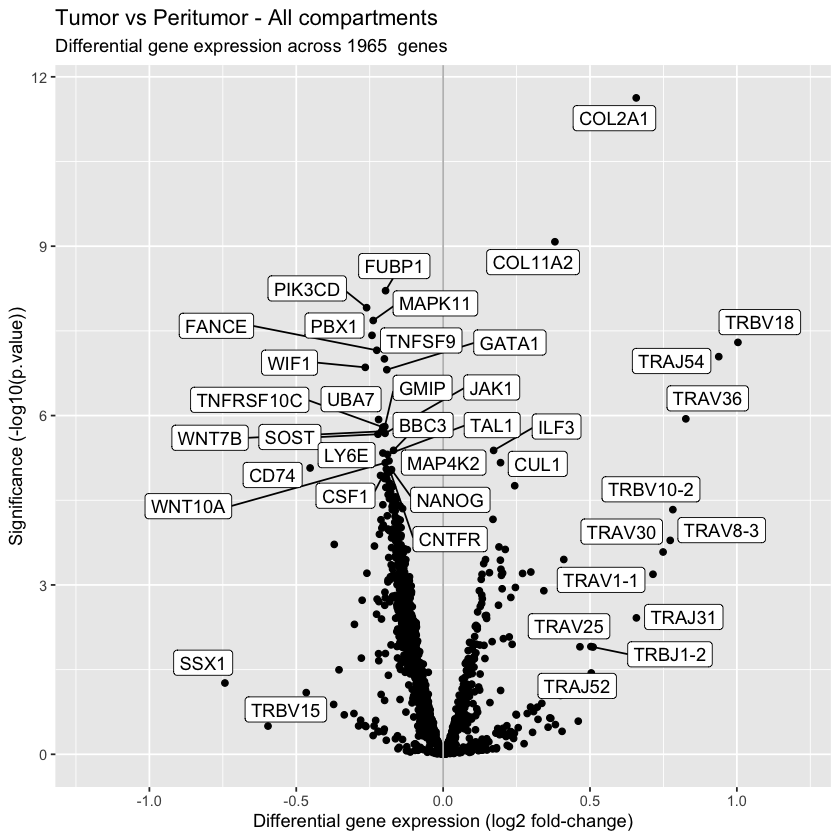

In [11]:
all_table %>%
    mutate(
        `label`=case_when(
            abs(`logFC`) >= 0.5 ~ str_replace_all(`gene`, ',.*', ''),
            -log10(`P.Value`) > 5 ~ str_replace_all(`gene`, ',.*', ''),
            TRUE ~ ''
        )
    ) %>%
    ggplot(aes(x=`logFC`, y=-log10(`P.Value`))) +
        geom_point() +
        geom_vline(xintercept=0, color='gray') +
        geom_label_repel(aes(label=`label`), max.overlaps=Inf) +
        labs(
            x='Differential gene expression (log2 fold-change)',
            y='Significance (-log10(p.value))',
            title='Tumor vs Peritumor - All compartments',
            subtitle=paste('Differential gene expression across', nrow(all_table), ' genes')
        ) +
        xlim(-1.2, 1.2)


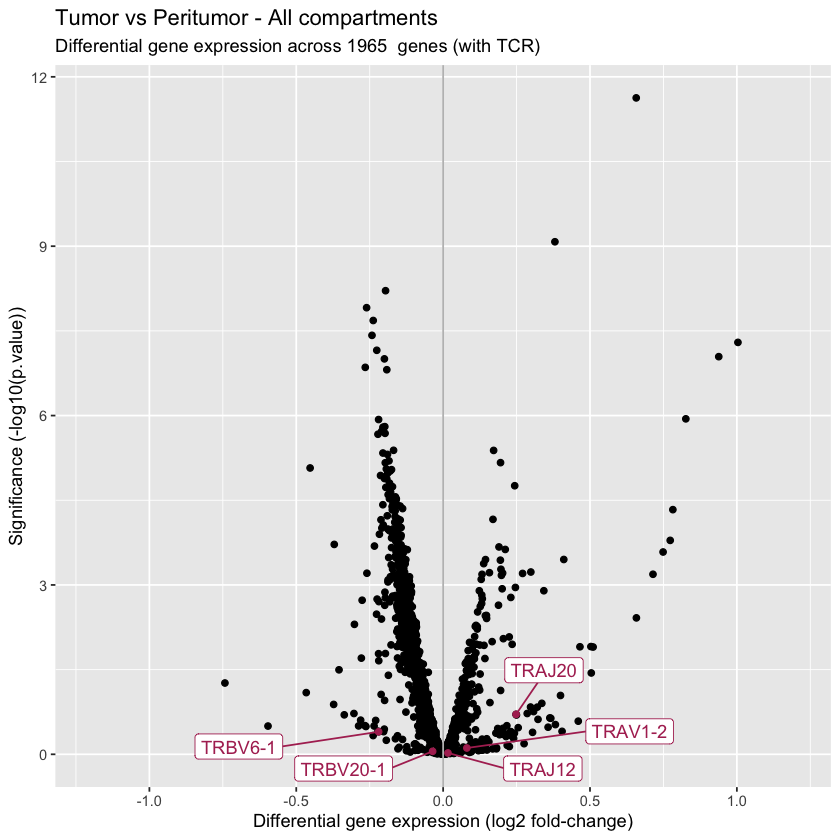

In [12]:
all_table %>%
    mutate(
        `label`=case_when(
            `gene` %in% c('TRAJ12', 'TRAJ20', 'TRAJ33', 'TRAV1-2', 'TRBV20-1', 'TRBV6-1') ~ `gene`,
            TRUE ~ ''
        )
    ) %>%
    ggplot(aes(x=`logFC`, y=-log10(`P.Value`))) +
        geom_point() +
        geom_point(data=. %>% filter(`label` != ''), color='maroon') +
        geom_vline(xintercept=0, color='gray') +
        geom_label_repel(aes(label=`label`), max.overlaps=Inf, color='maroon') +
        labs(
            x='Differential gene expression (log2 fold-change)',
            y='Significance (-log10(p.value))',
            title='Tumor vs Peritumor - All compartments',
            subtitle=paste('Differential gene expression across', nrow(all_table), ' genes (with TCR)')
        ) +
        xlim(-1.2, 1.2)


In [13]:
all_table %>%
    filter(`logFC` > 0.5)

gene,logFC,AveExpr,t,P.Value,adj.P.Val,B
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
COL2A1,0.6573349,9.360608,7.680655,2.360967e-12,4.639301e-09,17.6034857
TRBV18,1.0036106,9.415918,5.758504,5.054978e-08,9.933032e-05,8.1558626
TRAJ54,0.9383319,9.323525,5.636491,9.046191e-08,1.777577e-04,7.6075430
TRAV36,0.8262317,9.409111,5.085125,1.142902e-06,2.245802e-03,5.2225193
TRBV10-2,0.7820530,9.443028,4.202939,4.639097e-05,9.115826e-02,1.7654834
TRAV8-3,0.7730782,9.509456,3.874884,1.624504e-04,3.192150e-01,0.5999141
TRAV30,0.7488119,9.486580,3.745645,2.609406e-04,5.127482e-01,0.1641736
TRAV1-1,0.7144177,9.520336,3.488690,6.468813e-04,1.000000e+00,-0.6668761
TRAJ31,0.6579233,9.550359,2.940137,3.831881e-03,1.000000e+00,-2.2943709


In [14]:
all_table %>%
    filter(`logFC` > 0.2)

gene,logFC,AveExpr,t,P.Value,adj.P.Val,B
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
COL2A1,0.6573349,9.360608,7.6806549,2.360967e-12,4.639301e-09,17.6034857
COL11A2,0.3805664,9.322852,6.5822450,8.347312e-10,1.640247e-06,12.0311245
TRBV18,1.0036106,9.415918,5.7585044,5.054978e-08,9.933032e-05,8.1558626
TRAJ54,0.9383319,9.323525,5.6364910,9.046191e-08,1.777577e-04,7.6075430
TRAV36,0.8262317,9.409111,5.0851249,1.142902e-06,2.245802e-03,5.2225193
NDUFA13,0.2437159,9.389575,4.4463697,1.749884e-05,3.438523e-02,2.6670015
TRBV10-2,0.7820530,9.443028,4.2029389,4.639097e-05,9.115826e-02,1.7654834
TRAV8-3,0.7730782,9.509456,3.8748835,1.624504e-04,3.192150e-01,0.5999141
BTK,0.2115306,9.227052,3.7742730,2.351677e-04,4.621046e-01,0.2991179
